### 一.GCN原理   

**1.1  问题1：** 先看一个例子，假如我们有如下的5个用户，他们编号为0~4，且知道他们的关系如下，假如我们现在面对的是车险反欺诈的预测场景，已知编号1，2的为欺诈客户（正样本），编号4的为正常客户（负样本），现在要我们预测剩下的编号0，3的客户是欺诈客户还是正常客户？该怎么办呢？   
![avatar](./pic/gcn_demo1.jpg)  

我想基于前三节的内容至少可以有两个思路：   

（1）基于度指标：计算当前节点的邻居节点中欺诈客户的占比，那么0号客户周围1/1的客户都是欺诈客户，所以他也是欺诈客户，而客户3周围有2/3的客户都是欺诈客户，所以他也是欺诈客户   
（2）基于Graph Embedding：基于DeepWalk或者Node2Vec的方式为每个用户学习一个Embedding，然后计算它与邻居Embedding的相似度，然后统计累计相似度占比最高的标签为当前节点的标签，或者直接将这些Embedding送到一个分类器进行训练    

**1.2 问题2：** 而我们在处理实际数据时，可能并不仅仅只有他们之间的关系数据，还会有他们各自的因子数据，比如年龄，最近半年的贷款额，最近一月的消费额度这三项，我们将其加到图中（已经归一化处理）   

![avatar](./pic/gcn_demo2.jpg)

那现在如何处理？以往我们可能会只利用他们的因子数据来构建分类模型，比如使用lgbm对这三维度的因子建模预测，但这样又少了结构信息；那如果只利用了上面的结构信息建模又少了因子数据（当然你也可以尝试将Embedding+因子结合起来），那有没有办法同时利用结构信息和因子信息呢？这可以从CNN的卷积操作进行借鉴   

**1.3 更一般的认识CNN:** 让我们重新理解一下CNN中卷积操作，
>1) 卷积操作本质上是将某视野域内的像素点数据进行加权聚合，如下图左边将红色区块附近的8个绿块数据加权聚合到红块中（通常会包含红块自身的数据）；  
>2) 那如果我们将这些像素点强行拉开呢？这中间的图不就是一个图结构了吗？（而且现在的边时带权重的，它的权重就对应了卷积块上的数值）；  
>3) 那如果我们再将中图中的某些边切掉，那不就是更一般的图结构了

![avatar](./pic/gnn_cnn理解1.jpg)   

所以，我们完全可以利用CNN的方式来处理GNN：**将周围邻居的信息加权聚合到中心节点**，这便是GCN的基本思路了：   

1）节点上的信息就是我们的因子，比如上面的年龄，最近半年的贷款额，最近一月的消费额...   
2）而对邻居的加权聚合便是对于结构信息的处理...   

如此这样，就能同时利用节点的因子信息和结构信息了，下面介绍GCN的详细推导   

**1.4 GCN推导**   

**结构上**：   

与CNN类似，当前节点的更新信息由当前节点的信息和周围邻居信息累加得到，对于图结构而言，我们需要为每个节点添加一个自连接
![avatar](./pic/gcn_demo3.jpg)  

比如对于节点1，它的更新后的信息就是：   

$$
[0.4,0.2,0.7]+[0.2,0.3,0.5]+[0.3,0.3,0.5]+[0.4,0.2,0.3]=[1.3,1.0,2.0]
$$  

再比如，对于节点4，它的更新后的信息就是：   

$$
[0.2,0.4,0.3]+[0.4,0.2,0.3]=[0.6,0.6,0.6]
$$  

想必，你也发现问题了，对于邻居很多的节点，聚合后的数值会比其它邻居少的节点大很多，所以我们需要进行归一化，GCN是采用的归一化方式如下，对于节点$v_i,v_j$，它们的度为$d(v_i),d(v_j)$，聚合信息时，会在它们前面乘以一个权重，即度的乘积的平方根的倒数：    

$$
\frac{1}{\sqrt{d(v_i)}\cdot \sqrt{d(v_j)}}
$$  

所以，这时对于节点1的更新就是：   

$$
\frac{1}{4}[0.4,0.2,0.7]+\frac{1}{2\sqrt{2}}[0.2,0.3,0.5]+\frac{1}{2\sqrt{3}}[0.3,0.3,0.5]+\frac{1}{2\sqrt{3}}[0.4,0.2,0.3]
$$   

上面的更新操作，可以对$X$左乘一个矩阵来进行计算：   

$$
\tilde{L}_{sym}X
$$  

这里的$X$就是我们的因子数据，第$i$行就是第$i$个因子的向量表示，比如$X_{0,:}=[0.2,0.3,0.5]$，而   

$$
\tilde{L}_{sym}=\tilde{D}^{-1/2}\tilde{A}\tilde{D}^{-1/2},\tilde{A}=A+I,\tilde{D_{ii}}=\sum_j\tilde{A}_{ij}
$$  

这里的$A$是连接矩阵，$I$是单位矩阵，所以$\tilde{A}X$，就是添加了自连接且没加权的聚合表示，即最上面的表示，如节点1的聚合   

$$
[0.4,0.2,0.7]+[0.2,0.3,0.5]+[0.3,0.3,0.5]+[0.4,0.2,0.3]=[1.3,1.0,2.0]
$$  

而$\tilde{D}$是$\tilde{A}$的度矩阵，它只有对角线上有值，$\tilde{D}_{ii}$的值就是$\tilde{A}$的第$i$行求和，所以$\tilde{A}$矩阵前后分别乘一个$\tilde{D}^{-1/2}$相等于乘以了上文介绍的权重$\frac{1}{\sqrt{d(v_i)}\cdot \sqrt{d(v_j)}}$

**因子上：**    

可以发现$\tilde{L}_{sym}X$中的$\tilde{L}_{sym}$和$X$都是已知的，GCN希望增强模型的表达能力，所以对于$\tilde{L}_{sym}X$在特征上再做了一次线性变换，等价于右乘一个变量矩阵$W$，为了进一步增强表达能力，通常还会对结果进行一个非线性变换$\sigma$，所以最终的更新公式如下：   

$$
X'=\sigma(\tilde{L}_{sym}XW)
$$  

需要注意的是，$W$是对每一层的所有节点共享的，这里可以将其类比为CNN中的卷积核系数   

**如何训练？**  

这就和其它ML的任务一样的，构造一个损失函数$loss(X',Y)$，然后基于梯度，更新参数$W$即可，比如($\eta$为学习率)：

$$
W\leftarrow W-\eta\frac{\partial loss(X',Y)}{\partial W}
$$  

### 二.代码实践
下面仅演示代码的核心部分   

**2.1 加载数据并构建$\tilde{L}_{sym}$**

In [1]:
from code.gcn import *

In [2]:
#加载数据
dataset = CoraData().data

Using Cached file: E:\datas\Algs\GNN\cora\processed_cora.pkl
Cached file: E:\datas\Algs\GNN\cora\processed_cora.pkl


**链接矩阵**：表示文章之间的引用关系，这里是稀疏矩阵的格式

In [3]:
dataset.adjacency

<2708x2708 sparse matrix of type '<class 'numpy.float32'>'
	with 10556 stored elements in COOrdinate format>

**因子信息**：2708X1433的矩阵，即2708篇文章的BOW表示

In [4]:
dataset.x

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

**标签信息**：2708X1，分别标记了2708篇文章的7种类别

In [5]:
dataset.y

array([3, 4, 4, ..., 3, 3, 3], dtype=int64)

**构建$\tilde{L}_{sym}$的代码**：  

```python
def normalization(adjacency):
    """计算 L=D^-0.5 * (A+I) * D^-0.5"""
    adjacency += sp.eye(adjacency.shape[0])
    # 增加自连接
    degree = np.array(adjacency.sum(1))
    d_hat = sp.diags(np.power(degree, -0.5).flatten())
    return d_hat.dot(adjacency).dot(d_hat).tocoo()
```

In [6]:
#如果有GPU则使用GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
#接着预处理剩下的数据
x = dataset.x / dataset.x.sum(1, keepdims=True)
# 归一化数据，使得每一行和为1
tensor_x = torch.from_numpy(x).to(device)
tensor_y = torch.from_numpy(dataset.y).to(device)
tensor_train_mask = torch.from_numpy(dataset.trn_mask).to(device)
tensor_val_mask = torch.from_numpy(dataset.val_mask).to(device)
tensor_test_mask = torch.from_numpy(dataset.test_mask).to(device)
normalize_adjacency = normalization(dataset.adjacency)
# 规范化邻接矩阵
indices = torch.from_numpy(np.asarray([normalize_adjacency.row, normalize_adjacency.col])).long()
values = torch.from_numpy(normalize_adjacency.data.astype(np.float32))
tensor_adjacency = torch.sparse.FloatTensor(indices, values, (2708, 2708)).to(device)

**2.2 构建模型**  

这部分代码拆分为了两块，   

1）第一块是对单次图卷积的操作，对应上面的公式：$X'=\sigma(\tilde{L}_{sym}XW)$，代码如下(这里并没有实现激活函数的功能)：   

```python
class GraphConvolution(nn.Module):
    def __init__(self, input_dim, output_dim, use_bias=True):
        """图卷积
        input_dim: 节点输入特征的维度
        output_dim: 输出特征维度 
        use_bias : bool, optional"""
        super(GraphConvolution, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.use_bias = use_bias
        self.weight = nn.Parameter(torch.Tensor(input_dim, output_dim))
        if self.use_bias:
            self.bias = nn.Parameter(torch.Tensor(output_dim))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight)
        if self.use_bias:
            nn.init.zeros_(self.bias)

    def forward(self, adjacency, input_feature):
        """
        adjacency: 经过上面归一化后的链接矩阵，即\tilde{L}_{sym}
        input_feature:输入特征，即X """
        support = torch.mm(input_feature, self.weight)
        output = torch.sparse.mm(adjacency, support)
        if self.use_bias:
            output += self.bias
        return output
```  

2）第二块代码叠加了两层图卷积，第一层将1433维的BOW降低到16维，第二层将16维降低到7维，对应到我们的类别数   

```python
class GCNNet(nn.Module):
    """ 定义一个包含两层GraphConvolution的模型 """

    def __init__(self, input_dim=1433):
        super(GCNNet, self).__init__()
        self.gcn1 = GraphConvolution(input_dim, 16)
        self.gcn2 = GraphConvolution(16, 7)

    def forward(self, adjacency, feature):
        h = F.relu(self.gcn1(adjacency, feature))
        logits = self.gcn2(adjacency, h)
        return logits
```

In [7]:
#构建模型
model = GCNNet().to(device)

**2.3 训练模型**  

主要包括：   
1）损失函数定义   
2）优化器定义  
3）训练过程：  <1>前向得到loss ； <2>loss反向更新参数

In [12]:
# 超参数定义
learning_rate = 0.1
weight_decay = 5e-4
epochs = 200
# 损失函数使用交叉熵
criterion = nn.CrossEntropyLoss().to(device)
# 优化器使用Adam
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
# 训练
loss_history = []
val_acc_history = []
model.train()
train_y = tensor_y[tensor_train_mask]
for epoch in range(epochs):
    # 前向传播
    logits = model(tensor_adjacency, tensor_x)
    # 只选择训练节点进行监督
    train_mask_logits = logits[tensor_train_mask]
    # 计算损失值
    loss = criterion(train_mask_logits, train_y)
    # 反向传播计算参数的梯度
    optimizer.zero_grad()
    loss.backward()
    # 使用优化方法进行梯度更新
    optimizer.step()

**2.4 预测并查看效果**

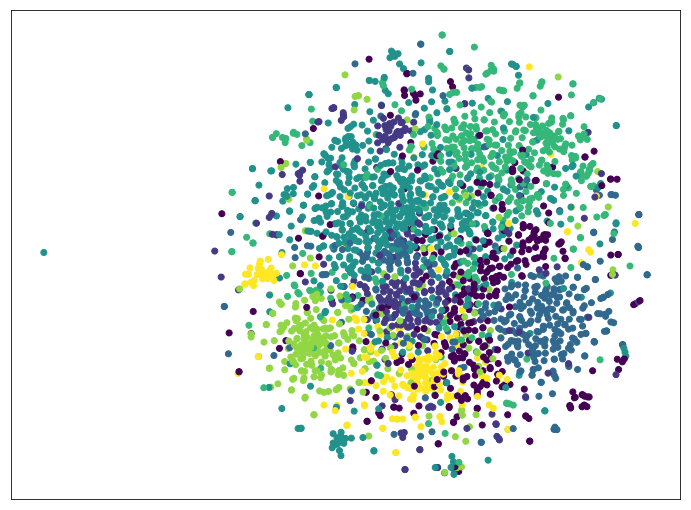

In [13]:
# tsne降维，查看效果
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
%matplotlib inline
#对X用tsne降维
from sklearn import manifold
tsne = manifold.TSNE(n_components=2,init="pca")
X_tsne = tsne.fit_transform(tensor_x.numpy())
#预测
pred = model(tensor_adjacency, tensor_x).max(1)[1].numpy()
#归一化显示
x_min, x_max = X_tsne.min(0), X_tsne.max(0)
X_norm = (X_tsne - x_min) / (x_max - x_min)
plt.figure(figsize=(12, 9))
plt.scatter(X_norm[:,0],X_norm[:,1],c=pred)
plt.yticks([])
plt.xticks([])
plt.show()